## Задание 2

К вам поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

## Шаг 1: Подготовка данных

Подгрузим, необходимые библиотеки:

In [51]:
import pandas as pd
import numpy as np
from plotly.offline import iplot
import plotly.graph_objs as go
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import date
from fbprophet import Prophet

Загрузим данные, посмотрим на них:

In [100]:
# Загрузим данные руками, в случае большего набора данных их следовало бы спарсить
d = {'date':['2020-01-05','2020-01-12','2020-01-19','2020-01-26','2020-02-02','2020-02-09','2020-02-16','2020-02-23',
          '2020-03-01','2020-03-08','2020-03-15','2020-03-22','2020-03-29','2020-04-05'], 
     'orders':[650, 837, 1020, 1176, 1489, 1823, 1991, 2166, 2334, 2607, 2734, 3492, 3608, 3857]}
df = pd.DataFrame(data=d)
df['date'] = pd.to_datetime(df.date)
df

,date,orders
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


**Данные есть на 3 месяца, прогноз нужен на 3 месяца, грануляция данных очень велика — адекватно спрогнозировать такой временной отрезок, невозможно, множество факторов не будут учтены(сезонность, тренд и.др.)**

Но сделав оговорку что:
- представленные данные в полной мере отражают динамику роста числа заказов
- рамках прогнозируемых 3х месяцев, не будет слома тренда или каких либо аномалий

попробуем построить хоть сколько нибудь точный прогноз, имея ввиду что данных мало и точность прогноза не велика.

## Шаг 2: Попробуем спрогнозировать

### Сначала посмотрим, общие метрики и тенденции

In [44]:
iplot([go.Scatter(x=df['date'], y=df['orders'], name='fact')])

Тренд более менее линеен, в условиях сказано что была проведена акция увеличившая продажи на 7%, но это не очень заметно, зато есть очевидный пик на 11 месяце. Еще раз отметим, что данных маловато и, очевидно, не будут учтены все ньюансы.

Посчитаем средний прирост продаж день ко дню, отражающий динамику:

In [45]:
df['orders_diff'] = df.orders.diff()
df

,date,orders,orders_diff
0,2020-01-05,650,NaN
1,2020-01-12,837,187.0
2,2020-01-19,1020,183.0
3,2020-01-26,1176,156.0
4,2020-02-02,1489,313.0
5,2020-02-09,1823,334.0
6,2020-02-16,1991,168.0
7,2020-02-23,2166,175.0
8,2020-03-01,2334,168.0
9,2020-03-08,2607,273.0


Посмотрим на статистические характеристики прироста:

In [46]:
print('Минимальная разница', df['orders_diff'].min())
print('Максимальная разница', df['orders_diff'].max())
print('Средняя разница', df['orders_diff'].mean())
print('Медианная разница', df['orders_diff'].median())

Минимальная разница 116.0
Максимальная разница 758.0
Средняя разница 246.69230769230768
Медианная разница 183.0


Визуализируем:

In [47]:
df['orders_min'] = df['orders_diff'].min()
df['orders_max'] = df['orders_diff'].max()
df['orders_mean'] = df['orders_diff'].mean()
df['orders_median'] = df['orders_diff'].median()

In [48]:
iplot([
    go.Scatter(x=df['date'], y=df['orders'], name='fact'),
    go.Scatter(x=df['date'], y=df['orders_diff'], name='diff'),
    go.Scatter(x=df['date'], y=df['orders_mean'], name='mean'),
    go.Scatter(x=df['date'], y=df['orders_median'], name='median'),
])

## Спрогнозируем продажи простой линейной моделью

В начале посмотрим, как линейная модель, прогнозирует текущие данные

In [87]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]).reshape((-1, 1))
y = np.array([650,837,1020,1176,1489,1823,1991,2166,2334,2607,2734,3492,3608,3857])

In [88]:
model = LinearRegression()

In [89]:
model.fit(x,y)

LinearRegression()

In [90]:
y_pred = model.predict(x)

In [91]:
iplot([
    go.Scatter(x=df['date'], y=df['orders'], name='fact'),
    go.Scatter(x=df['date'], y=model.predict(x_new), name='lin')
])

Спрогнозируем, вперед на 3 месяца

In [92]:
x_new = np.arange(26).reshape((-1, 1))

In [93]:
d = np.array(['2020-01-05','2020-01-12','2020-01-19','2020-01-26',
              '2020-02-02','2020-02-09','2020-02-16','2020-02-23',
              '2020-03-01','2020-03-08','2020-03-15','2020-03-22',
              '2020-03-29','2020-04-05',
              '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
              '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
              '2020-06-07', '2020-06-14', '2020-06-21'])

In [96]:
y_new = model.predict(x_new)

In [97]:
iplot([
    go.Scatter(x=df['date'], y=df['orders'], name='fact'),
    go.Scatter(x=d, y=model.predict(x_new), name='lin-NEW')])

## Спрогнозируем продажи с помощью библиотеки prophet

Загрузим данные для модели prophet:

In [110]:
d = {'ds':['2020-01-05','2020-01-12','2020-01-19','2020-01-26','2020-02-02','2020-02-09','2020-02-16','2020-02-23',
          '2020-03-01','2020-03-08','2020-03-15','2020-03-22','2020-03-29','2020-04-05'], 
     'y':[650, 837, 1020, 1176, 1489, 1823, 1991, 2166, 2334, 2607, 2734, 3492, 3608, 3857]}
df = pd.DataFrame(data=d)
df['ds'] = pd.to_datetime(df.ds)

Добавим в модель информацию о проведении акции, давшей прирост 7%:

In [111]:
df['coef'] = 1
df.loc[(df.ds == '2020-02-02') | (df.ds == '2020-02-09'),'stock_coef'] = 0.93
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False ,n_changepoints=0)
model.add_regressor('coef')

In [112]:
model.fit(df)

In [113]:
pred_data = model.make_future_dataframe(periods=12,freq='W') 
pred_data['coef'] = 1
pred_data.loc[(pred_data.ds == '2020-02-02') | (pred_data.ds == '2020-02-09'),'coef'] = 0.93
predictions = model.predict(pred_data)

Визуализируем прогноз:

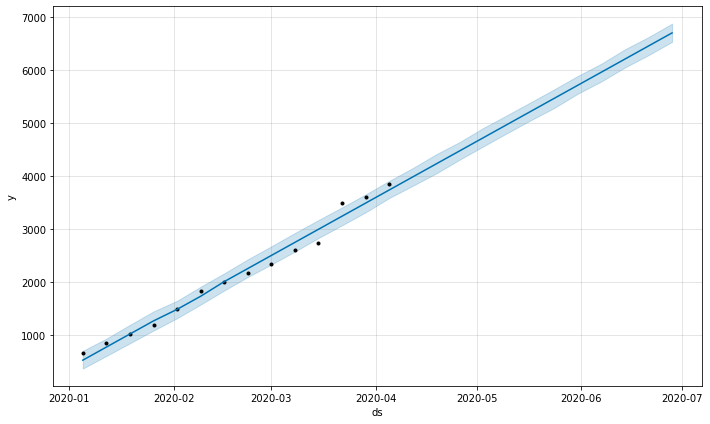

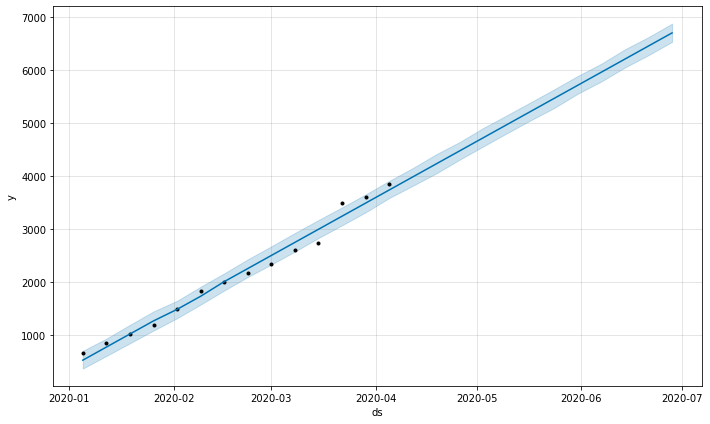

In [116]:
model.plot(predictions) 